# Simulating Invasion

Studying the impact of multiphase conditions on transport in porous materials was the original motivation for pore network modeling. OpenPNM includes a set of algorithms for simulating drainage (i.e. non-wetting phase invasion) using both ordinary and invasion percolation. These will be covered in this notebook.

In [96]:
import openpnm as op
import numpy as np
import matplotlib.pyplot as plt

Setup the necessary objects:

In [97]:
pn = op.network.Demo(shape=[20, 20, 1], spacing=1e-4)
air = op.phase.Air(network=pn)

The `air` phase created above need some physics model that relates fluid properties like surface tension and contact angle, to geometric properties such pore and throat diameter.  Let's assume that water is the wetting phase, and air is non-wetting, with a contact angle of 120 degrees, and let's also use the Washburn equation to compute the capillary entry pressure.

In [98]:
air['pore.contact_angle'] = 120
air['pore.surface_tension'] = 0.072
f = op.models.physics.capillary_pressure.washburn
air.add_model(propname='throat.entry_pressure',
              model=f, 
              surface_tension='throat.surface_tension',
              contact_angle='throat.contact_angle',
              diameter='throat.diameter',)

## Drainage

Drainage refers to the process of a non-wetting fluid displacing a wetting fluid, by application of increasingly high capillary pressures where $ P_c = P_{nwp} - P_{wp} $.  Thus, either the non-wetting phase pressure can be increased, or the wetting phase pressure can be decreased (i.e. suction).  The term "drainage" stems from the process of *draining* water from a sand column, where water is the wetting phase and air is non-wetting, but applies to any case regardless of which fluids are involved. When it is not clear which fluid is wetting or not, it is best to use the terms *injection* and *withdrawal* to avoid confusion.

To simulate drainage, we must create a `Drainage` object, which requires specifying the non-wetting, or invading phase. The invading phase object (`air`) contains the information about the capillary pressure required for it to invade a throat (and subsequently the pore beyond it). We also must tell the algorithm where the invasion starts from.  Finally we can run it:

In [103]:
drn = op.algorithms.Drainage(network=pn, phase=air)
drn.set_inlet_BC(pores=pn.pores('left'))
drn.run()

Performing drainage simulation: 100%|█████████████████████████████████████████████████| 25/25 [00:00<00:00, 501.67it/s]


The result of running the algorithm is that several new arrays are added to the `drn` object. Specifically, there are arrays containing the pressure at which each pore and throat was invaded, as well as the sequence.  

In [104]:
print(drn)


══════════════════════════════════════════════════════════════════════════════
drainage_03 : <openpnm.algorithms.Drainage at 0x167a2f6e540>
――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――
  #  Properties                                                   Valid Values
――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――
  1  pore.invasion_pressure                                          400 / 400
  2  pore.invasion_sequence                                          400 / 400
  3  throat.invasion_pressure                                        760 / 760
  4  throat.invasion_sequence                                        760 / 760
――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――
  #  Labels                                                 Assigned Locations
――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――
  1  pore.all                                                        

The `'invasion_pressure'` and `'invasion_sequence'` arrays are quite useful because the actaully contain the entire invasion history in a single array.  We can obtain the invasion pattern at any applied pressure by doing:

In [113]:
inv_pattern = drn['throat.invasion_pressure'] < 9000

Now we can plot only the invaded throats:

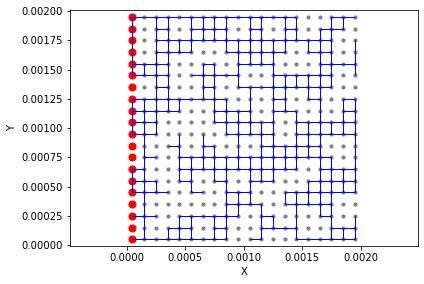

In [114]:
ax = op.visualization.plot_coordinates(network=pn, pores=pn.pores('left'), c='r', s=50)
ax = op.visualization.plot_coordinates(network=pn, pores=pn.pores('left', mode='not'), c='grey', ax=ax)
op.visualization.plot_connections(network=pn, throats=inv_pattern, ax=ax);

We can also apply trapping, which is done as a post processing step. This requires first specifying the outlet pores through which the wetting phase can escape, then running the `apply_trapping` method, which alters the `'invasion_pressure'` and `'invasion_sequence'` arrays. It sets `'invasion_pressure'` and `'invasion_sequence'` to `inf` to indicated trapped by pores/throats, so that they are not found when doing `drn['throat.invasion_pressure'] < p`. 

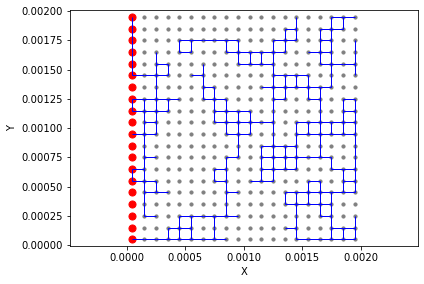

In [118]:
drn.set_outlet_BC(pores=pn.pores('right'), mode='overwrite')
drn.apply_trapping()
inv_pattern = drn['throat.invasion_pressure'] < 9000
ax = op.visualization.plot_coordinates(network=pn, pores=pn.pores('left'), c='r', s=50)
ax = op.visualization.plot_coordinates(network=pn, pores=pn.pores('left', mode='not'), c='grey', ax=ax)
op.visualization.plot_connections(network=pn, throats=inv_pattern, ax=ax);

One of the main uses of the `Drainage` algorithm is to simulate capillary pressure curves, and specifical mercury intrusion porosimetry. One of the main ways to calibrate a PNM is to ensure that the simulated MIP curve matches experimental data. Let's simulate this:

In [122]:
pn = op.network.Demo(shape=[20, 20, 1], spacing=1e-4)
hg = op.phase.Mercury(network=pn)
f = op.models.physics.capillary_pressure.washburn
hg.add_model(propname='throat.entry_pressure',
             model=f, 
             surface_tension='throat.surface_tension',
             contact_angle='throat.contact_angle',
             diameter='throat.diameter',)
mip = op.algorithms.Drainage(network=pn, phase=hg)
mip.set_inlet_BC(pores=pn.pores('surface'))  # mercury invades froma all sides
mip.run()

Performing drainage simulation: 100%|█████████████████████████████████████████████████| 25/25 [00:00<00:00, 523.36it/s]


The `Drainage` class has a `pc_curve` method, which returns a `namedtuple` with `pc` and `snwp` data attributes that can be directly plotted:

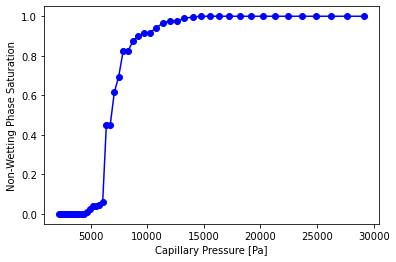

In [123]:
data = mip.pc_curve()
plt.plot(data1.pc, data1.snwp, 'b-o')
plt.xlabel('Capillary Pressure [Pa]')
plt.ylabel('Non-Wetting Phase Saturation');

Trapping does not occur in an MIP experiment since the wetting phase (air) is evacuated, but we can still apply trapping to the simulations just for demonstration purposes:

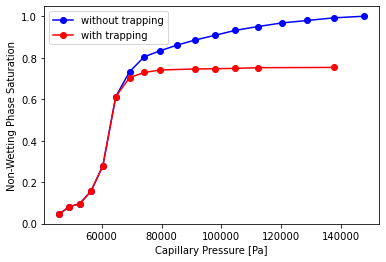

In [127]:
mip.set_outlet_BC(pores=pn.pores('right'), mode='overwrite')
mip.apply_trapping()
data2 = mip.pc_curve()
plt.plot(data.pc, data.snwp, 'b-o', label='without trapping')
plt.plot(data2.pc, data2.snwp, 'r-o', label='with trapping')
plt.xlabel('Capillary Pressure [Pa]')
plt.ylabel('Non-Wetting Phase Saturation')
plt.legend();

The impact of trapping is that the non-wetting phase saturations does not reach 1.0, but plateaus at some lower value. 

.. warning:: Inlet pores start invaded

    The curve shown above starts at a non-wetting phase saturation slightly above 0.  This is because the inlet pores are set to invaded to begin the algorithm. If the domain is large this is not really noticable. To be fully rigorous, one should actually add "boundary pores" to the domain, which are fictitious pores that have no volume.

## Invasion Percolation



In [77]:
ip = op.algorithms.InvasionPercolation(network=pn, phase=water)
pn['pore.volume@left'] = 0.0
ip.set_inlet_BC(pores=pn.pores('left'))
ip.run()

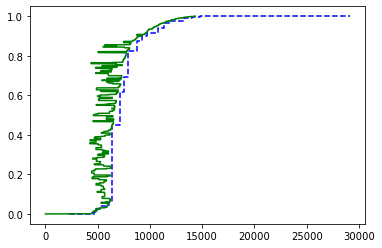

In [78]:
data_ip = ip.pc_curve()
plt.step(data1.pc, data1.snwp, 'b--', where='post')
plt.plot(data_ip.pc, data_ip.snwp, c='green');